In [1]:
from easy21 import *
import numpy as np

- Apply Monte-Carlo control to Easy21. 
- [x] Initialise the value function to zero. 
- [x] Use a time-varying scalar step-size of αt = 1/N(st,at) 
- [x] and an ε-greedy exploration strategy with εt = N0/(N0 + N(st)), 
- [x] where N0 = 100 is a constant, 
- [x] N(s) is the number of times that state s has been visited, 
- [x] and N(s,a) is the number of times that action a has been selected from state s. 
- [x] Feel free to choose an alternative value for N0, if it helps producing better results. 
- [x] Plot the optimal value function V ∗ (s) = maxa Q∗ (s, a) using similar axes to the following figure taken from Sutton and Barto’s Blackjack example.

In [2]:
class MC_Agent:
    def __init__(self, environment, n0):
        self.n0 = float(n0)
        self.env = environment
        
        # N(s) is the number of times that state s has been visited
        # N(s,a) is the number of times that action a has been selected from state s.
        self.N = np.zeros((self.env.dealer_values_count,
                           self.env.player_values_count, 
                           self.env.actions_count))
        
        self.Q = np.zeros((self.env.dealer_values_count,
                           self.env.player_values_count, 
                           self.env.actions_count))
        # self.E = np.zeros((self.env.dealer_values_count,
        #                    self.env.player_values_count, 
        #                    self.env.actions_count))

        # Initialise the value function to zero. 
        self.V = np.zeros((self.env.dealer_values_count, self.env.player_values_count))
        
        self.count_wins = 0
        self.iterations = 0

#     def get_action(self, s):
#         a = Actions.hit
#         return a
    
        # get optimal action, with epsilon exploration (epsilon dependent on number of visits to the state)
    # ε-greedy exploration strategy with εt = N0/(N0 + N(st)), 
    def get_action(self, state):
        dealer_idx = state.dealer-1
        player_idx = state.player-1
        n_visits = sum(self.N[dealer_idx, player_idx, :])

        # epsilon = N0/(N0 + N(st)
        curr_epsilon = self.n0 / (self.n0 + n_visits)

        # epsilon greedy policy
        if random.random() < curr_epsilon:
            r_action = Actions.hit if random.random()<0.5 else Actions.stick
#             if (dealer_idx == 0 and player_idx == 0):
#                 print ("epsilon:%s, random:%s " % (curr_epsilon, r_action))
            return r_action
        else:
            action = Actions.to_action(np.argmax(self.Q[dealer_idx, player_idx, :]))
#             if (dealer_idx == 0 and player_idx == 0):
#                 print ("epsilon:%s Qvals:%s Q:%s" % (curr_epsilon, self.Q[dealer_idx, player_idx, :], action))
            return action

    def train(self, iterations):        
        
        # Loop episodes
        for episode in xrange(iterations):
            episode_pairs = []
            
            # get initial state for current episode
            s = self.env.get_start_state()
            
            # Execute until game ends
            while not s.term:
                
                # get action with epsilon greedy policy
                a = self.get_action(s)
                
                # store action state pairs
                episode_pairs.append((s, a))
                
                # update visits
                # N(s) is the number of times that state s has been visited
                # N(s,a) is the number of times that action a has been selected from state s. 
                self.N[s.dealer-1, s.player-1, Actions.as_int(a)] += 1
                
                # execute action
                s,r = self.env.step(s, a)

            #if episode%10000==0: print "Episode: %d, Reward: %d" %(episode, my_state.rew)
            self.count_wins = self.count_wins+1 if r==1 else self.count_wins

            # Update Action value function accordingly
            for curr_s, curr_a in episode_pairs:
                # print s.dealer, s.player, s.r, a
                dealer_idx = curr_s.dealer-1
                player_idx = curr_s.player-1
                action_idx = Actions.as_int(curr_a)
                
                # Use a time-varying scalar step-size of αt = 1/N(st,at) 
                step = 1.0 / sum(self.N[dealer_idx, player_idx, :])
                error = r - self.Q[dealer_idx, player_idx, action_idx]
                self.Q[dealer_idx, player_idx, action_idx] += step * error

        self.iterations += iterations
        print float(self.count_wins)/self.iterations*100

        # Derive value function
        for d in xrange(self.env.dealer_values_count):
            for p in xrange(self.env.player_values_count):
                self.V[d,p] = max(self.Q[d, p, :])
                
    def plot_frame(self, ax):
        def get_stat_val(x, y):
            return self.V[x, y]

        X = np.arange(0, self.env.dealer_values_count, 1)
        Y = np.arange(0, self.env.player_values_count, 1)
        X, Y = np.meshgrid(X, Y)
        Z = get_stat_val(X, Y)
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        return surf

# TODO 
#  add missing values
#  make train so it can be ran multiple sets of itteractions
#   (and figure out when to compute the value function and to make sure its done from start of file

In [3]:
# where N0 = 100 is a constant, 
N0 = 100

In [4]:
N0 = 100
agent = MC_Agent(Environment(), N0)
for i in xrange (10):
    agent.train(50000)

50.018
50.508
50.9506666667
51.1525
51.3256
51.4363333333
51.5508571429
51.62825
51.6582222222
51.7446


In [5]:
# Feel free to choose an alternative value for N0, if it helps producing better results.

In [6]:
# N0 = 300
# agent = MC_Agent(Environment(), N0)
# for i in xrange (10):
#     agent.train(50000)

In [7]:
# N0 = 30
# agent = MC_Agent(Environment(), N0)
# for i in xrange (10):
#     agent.train(50000)

## Plot

In [8]:
def animate(frame):
    i = agent.iterations
    step_size = i
    step_size = max(1, step_size)
    step_size = min(step_size, 2 ** 16)
    # agent.MC_run(100000)
    # agent.MC_run(step_size)
    agent.train(step_size)

    ax.clear()
    surf =  agent.plot_frame(ax)
    plt.title('MC score:%s frame:%s step_size:%s ' % (float(agent.count_wins)/agent.iterations*100, frame, step_size) )
    # plt.draw()
    fig.canvas.draw()
    print "done ", frame, step_size, i
    return surf

0.0
done  0 1 0
50.0
done  0 1 1
50.0
done  1 2 2
75.0
done  2 4 4
68.75
done  3 8 8
43.75
done  4 16 16
43.75
done  5 32 32
43.75
done  6 64 64
44.53125
done  7 128 128
41.6015625
done  8 256 256
42.7734375
done  9 512 512
43.45703125
done  10 1024 1024
44.921875
done  11 2048 2048
45.9594726562
done  12 4096 4096
47.6989746094
done  13 8192 8192
48.9837646484
done  14 16384 16384
50.1190185547
done  15 32768 32768
50.7598876953
done  16 65536 65536
50.9902954102
done  17 65536 131072
51.2233734131
done  18 65536 196608
51.3018798828
done  19 65536 262144
51.3816833496
done  20 65536 327680
51.46484375
done  21 65536 393216
51.5430450439
done  22 65536 458752
51.5986124674
done  23 65536 524288
51.6563415527
done  24 65536 589824
51.6903963956
done  25 65536 655360
51.7303466797
done  26 65536 720896
51.7224825346
done  27 65536 786432
51.7578125
done  28 65536 851968
51.7815144857
done  29 65536 917504
51.7777442932
done  30 65536 983040
51.7987419577
done  31 65536 1048576
51.794603

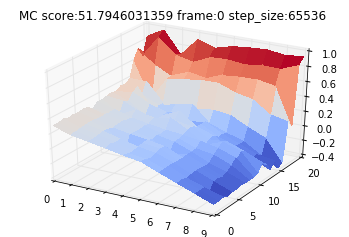

In [9]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline 

N0 = 100
agent = MC_Agent(Environment(), N0)
fig = plt.figure("N100")
ax = fig.add_subplot(111, projection='3d')

ani = animation.FuncAnimation(fig, animate, 32, repeat=False)

# note: requires gif writer; swap with plt.show()
ani.save('MC_Agent.gif', writer='imagemagick', fps=3)
# plt.show()

In [10]:
from IPython.display import Image
Image(url="MC_Agent.gif")

In [11]:
# Feel free to choose an alternative value for N0, if it helps producing better results.

100.0
done  0 1 0
50.0
done  0 1 1
50.0
done  1 2 2
62.5
done  2 4 4
56.25
done  3 8 8
56.25
done  4 16 16
53.125
done  5 32 32
53.90625
done  6 64 64
48.828125
done  7 128 128
45.703125
done  8 256 256
44.140625
done  9 512 512
42.87109375
done  10 1024 1024
43.4326171875
done  11 2048 2048
44.7265625
done  12 4096 4096
44.4519042969
done  13 8192 8192
44.3176269531
done  14 16384 16384
44.3939208984
done  15 32768 32768
44.5449829102
done  16 65536 65536
44.687906901
done  17 65536 131072
44.7261810303
done  18 65536 196608
44.7030639648
done  19 65536 262144
44.7209676107
done  20 65536 327680
44.6993146624
done  21 65536 393216
44.7061538696
done  22 65536 458752
44.7002834744
done  23 65536 524288
44.7387695312
done  24 65536 589824
44.7674837979
done  25 65536 655360
44.7835286458
done  26 65536 720896
44.7946401743
done  27 65536 786432
44.7789873396
done  28 65536 851968
44.775797526
done  29 65536 917504
44.7898864746
done  30 65536 983040
44.7836483226
done  31 65536 1048576


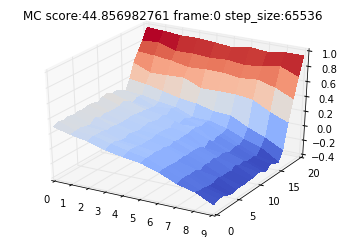

In [12]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline 

N0 = 1000000
agent = MC_Agent(Environment(), N0)
fig = plt.figure("N1000000")
ax = fig.add_subplot(111, projection='3d')

ani = animation.FuncAnimation(fig, animate, 50, repeat=False)

# note: requires gif writer; swap with plt.show()
ani.save('MC_Agent_N1000000.gif', writer='imagemagick', fps=3)
# plt.show()

In [13]:
from IPython.display import Image
Image(url="MC_Agent_N1000000.gif")

0.0
done  0 1 0
50.0
done  0 1 1
50.0
done  1 2 2
50.0
done  2 4 4
37.5
done  3 8 8
43.75
done  4 16 16
50.0
done  5 32 32
46.09375
done  6 64 64
44.53125
done  7 128 128
44.53125
done  8 256 256
46.09375
done  9 512 512
47.265625
done  10 1024 1024
47.3388671875
done  11 2048 2048
48.3642578125
done  12 4096 4096
49.1149902344
done  13 8192 8192
49.4354248047
done  14 16384 16384
49.6887207031
done  15 32768 32768
49.7673034668
done  16 65536 65536
50.0111897786
done  17 65536 131072
50.0957489014
done  18 65536 196608
50.0939941406
done  19 65536 262144
50.1243591309
done  20 65536 327680
50.1347133092
done  21 65536 393216
50.1184463501
done  22 65536 458752
50.0944349501
done  23 65536 524288
50.075378418
done  24 65536 589824
50.0894719904
done  25 65536 655360
50.0904083252
done  26 65536 720896
50.0821627103
done  27 65536 786432
50.0813075474
done  28 65536 851968
50.0719197591
done  29 65536 917504
50.083732605
done  30 65536 983040
50.0952327953
done  31 65536 1048576
50.0992

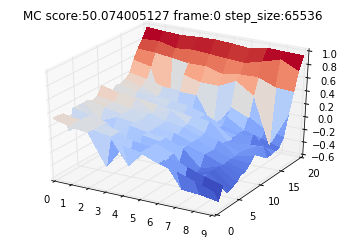

In [14]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline 

N0 = 1
agent = MC_Agent(Environment(), N0)
fig = plt.figure("N1")
ax = fig.add_subplot(111, projection='3d')

ani = animation.FuncAnimation(fig, animate, 50, repeat=False)

# note: requires gif writer; swap with plt.show()
ani.save('MC_Agent_N1.gif', writer='imagemagick', fps=3)
# plt.show()

In [15]:
from IPython.display import Image
Image(url="MC_Agent_N1.gif")

0.0
done  0 1 0
50.0
done  0 1 1
50.0
done  1 2 2
25.0
done  2 4 4
25.0
done  3 8 8
34.375
done  4 16 16
45.3125
done  5 32 32
39.0625
done  6 64 64
36.328125
done  7 128 128
40.625
done  8 256 256
43.26171875
done  9 512 512
43.017578125
done  10 1024 1024
44.384765625
done  11 2048 2048
45.0439453125
done  12 4096 4096
45.3369140625
done  13 8192 8192
46.2921142578
done  14 16384 16384
47.2717285156
done  15 32768 32768
48.3474731445
done  16 65536 65536
48.8789876302
done  17 65536 131072
49.3667602539
done  18 65536 196608
49.6713256836
done  19 65536 262144
49.9188741048
done  20 65536 327680
50.0823974609
done  21 65536 393216
50.2656936646
done  22 65536 458752
50.3904554579
done  23 65536 524288
50.5033874512
done  24 65536 589824
50.5722045898
done  25 65536 655360
50.6757100423
done  26 65536 720896
50.7508497972
done  27 65536 786432
50.8113316127
done  28 65536 851968
50.8758544922
done  29 65536 917504
50.9147644043
done  30 65536 983040
50.9786269244
done  31 65536 104857

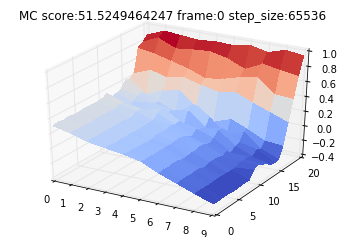

In [20]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline 

N0 = 1000
agent = MC_Agent(Environment(), N0)
fig = plt.figure("Nbest")
ax = fig.add_subplot(111, projection='3d')

ani = animation.FuncAnimation(fig, animate, 50, repeat=False)

# note: requires gif writer; swap with plt.show()
ani.save('MC_Agent_Nbest.gif', writer='imagemagick', fps=3)
# plt.show()

In [21]:
from IPython.display import Image
Image(url="MC_Agent_Nbest.gif")